# 常用融合方法

传统特征融合算法主要可以分为三类：
1. 基于贝叶斯决策理论的算法
2. 基于稀疏表示理论的算法
3. 基于深度学习理论算法。
传统方法不做整理，其中的深度学习方法按照融合的层次从下到上每一层都可以fusion：
- **pixel level**：对原始数据最小粒度进行融合。
- **feature level**：对抽象的特征进行融合，这也是用的最多的。包括early 和 late fusion，代表融合发生在特征抽取的早期和晚期，如上图。early是指先将特征融合后（concat、add）再输出模型，缺点是无法充分利用多个模态数据间的互补性，且存在信息冗余问题（可由PCA，AE等方法缓解）。late分融合和不融合两种形式，不融合有点像集成学习，不同模态各自得到的结果了之后再统一打分进行融合，好处是模型独立鲁棒性强。融合的方式即在特征生成过程中（如多层神经网络的中间）进行自由的融合，灵活性比较高，如金字塔融合。
- **decision level**：对决策结果进行融合，这就和集成学习很像了。
- **hybrid**：混合融合多种融合方法。

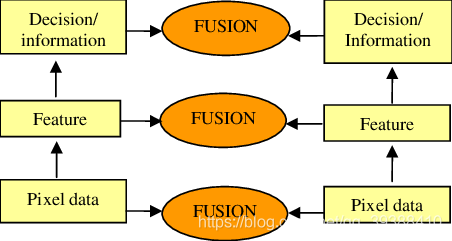

**以下代码中，设A模态特征维度为512，B模态特征维度为1024，C模态特征维度为32。**

In [ ]:
import torch
A = torch.randn(16, 512)
B = torch.randn(16, 1024)
C = torch.randn(16, 32)

## Concat法

concat法：最简单也是最常用的一种方式，直接在特征维度将不同模态特征进行拼接后，再送入后续的推理模块。

In [2]:
fusion_feature = torch.cat([A, B, C], dim=1)

NameError: name 'torch' is not defined

## TFN（tensor fusion network）融合策略

主要考虑了inter-modality和intar-modality两个方面。也就是要求既能考虑各模态之间的特征融合，也要有效地利用各特定模态的特征。

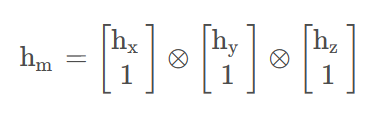

便得到了融合后的结果m，如下图：

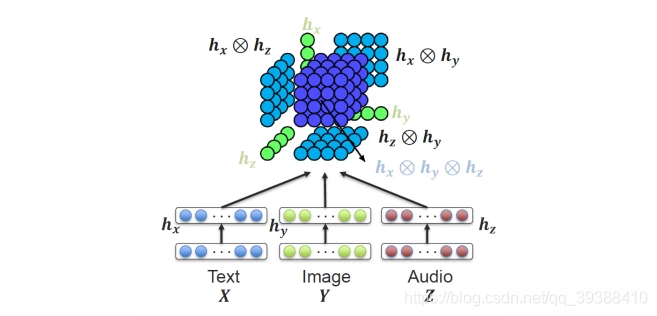

具体做法就是首先对每个模态用1进行维度扩充，然后对不同模态求笛卡尔积。

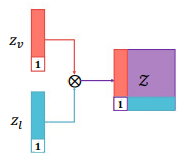

同理，对三个模态求得了笛卡尔积后，即计算了两两模态间的特征、三模态间的特征，又保留了各特定模态中的特征（见上图的Tensor Fusion细节）。

In [ ]:
n = A.shape[0]
# 用 1 扩充维度
A = torch.cat([A, torch.ones(n, 1)], dim=1)
B = torch.cat([B, torch.ones(n, 1)], dim=1)
C = torch.cat([C, torch.ones(n, 1)], dim=1)
# 计算笛卡尔积
A = A.unsqueeze(2)  # [n, A, 1]
B = B.unsqueeze(1)  # [n, 1, B]
fusion_AB = torch.einsum('nxt, nty->nxy', A, B)  # [n, A, B]
fusion_AB = fusion_AB.flatten(start_dim=1).unsqueeze(1) # [n, AxB, 1]
C = C.unsqueeze(1) # [n, 1, C]
fusion_ABC = torch.einsum('ntx, nty->nxy', fusion_AB, C) # [n, AxB, C]
fusion_ABC = fusion_ABC.flatten(start_dim=1)  # [n, AxBxC]
# A, B, C分别代表原来的特征维度nA,nB,nC加上1

**缺点：**TFN通过模态之间的张量外积（Outer product）计算不同模态的元素之间的相关性，但会极大的增加特征向量的维度，造成模型过大，难以训练。

## LWF（low rank weight）融合策略

上面提到的TFN对计算了两/三模态间的相关性，也保留了单模态的相关性，但同时也大大地增加了特征维度。增加特征维度从而会影响计算效率以及增加内存消耗，并且TFN所增加的时间/空间复杂度都与输入模态数呈指数增加。并且参数量一多，就容易增加过拟合的风险。
LMF是发表于ACL2017年的工作，针对TFN的上述问题，作者采用了low-rank weight进行多模态融合，降低参数量的同时还提升了计算速度。

TFN中的融合后的特征Z维度为**d1xd2xd3x....dm**，其中m表示模态数，i模态特征维度为di。
后续要将其送入推理模块中，通常需要降到h维的特征F，此时需要一个维度为**(d1xd2xd3x....dm)xh**的(M+1阶)权重W进行全连接操作。

全连接操作中，W可以视为h个M阶矩阵，每个矩阵与融合特征Z计算后的结果为F中的一维。

LMF要做的是就是将W分解成M组与各模态相关的low-rank因子。按照上述的视角，将W视为h个矩阵，每个特征矩阵**Wk**如下所示，其中使得分解成立的最小R称为秩(Rank)。

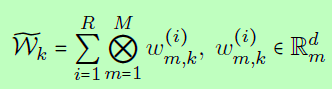

在LMF中，人为设定固定的秩r，得到每个**Wk**矩阵了，对特征矩阵进行重新排列，使其变为与模态m相关的特征**Wm**。

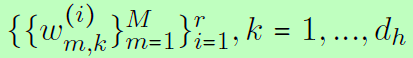

例子：3个模态时，秩为r，期望维度为h的情况：

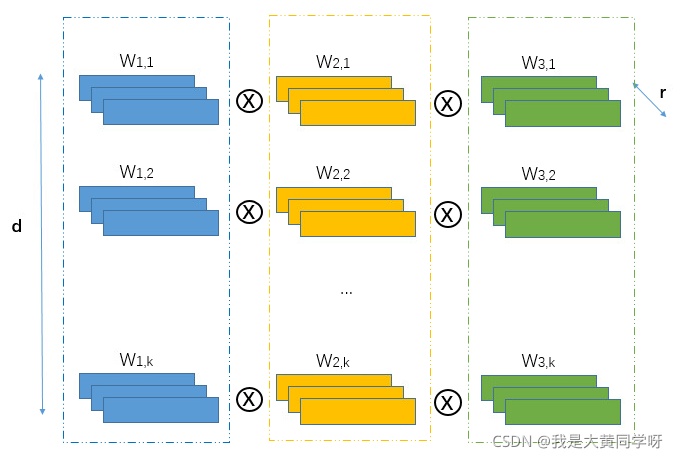

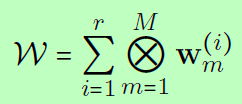

那么对特征变换**(Z→d维特征)**的过程可以拆分为如下过程：

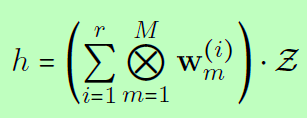

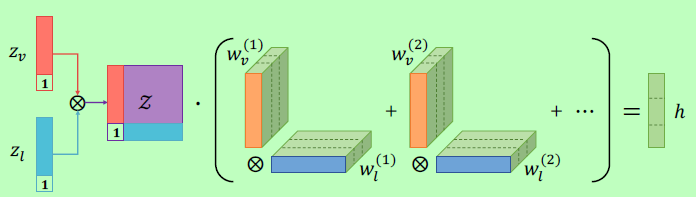

但Z本身也是由不同模态的外积得到的，那么组合起来可得到下式。

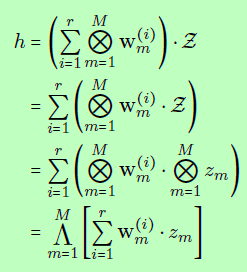

其中**Λ**表示像素级点乘。这样分解之后，避免了从各模态特征**Zm**去建模**Z**，并且可以扩展到不同数量的模态上，大大降低了时间复杂度。以3模态的融合为例，图例如下：

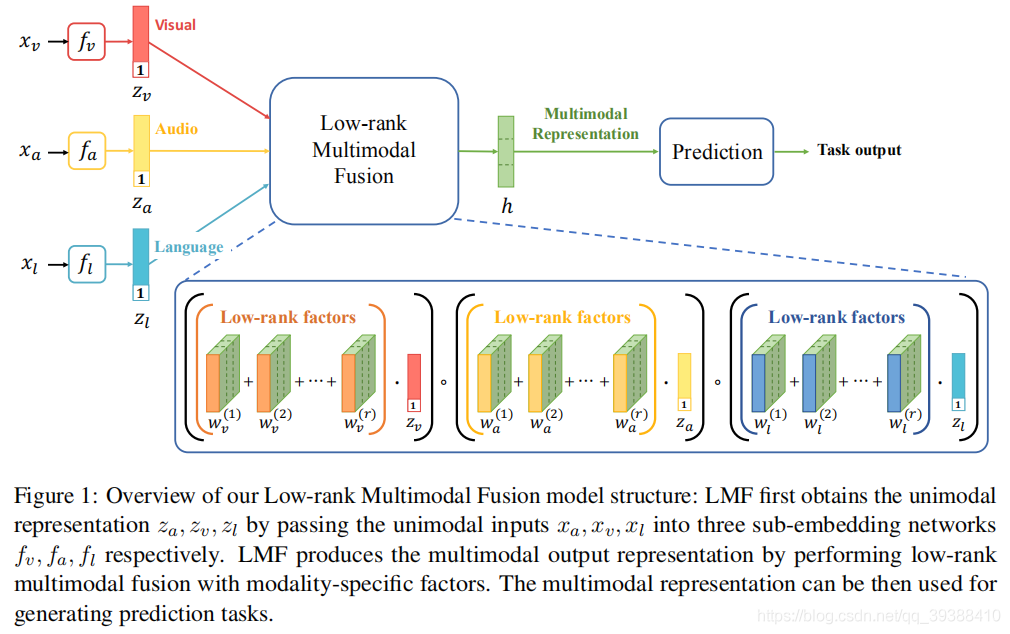

从上图可知，最后的由多模态特征**Zm**融合成**h维特征**的过程就变成了：每个模态分别构建r个权重矩阵，融合后对各模态特征进行矩阵乘法，得到一个h维的特征；然后再将各模态得到的h维特征进行像素级乘法即可。代码如下：

In [ ]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

A = torch.randn(16, 512)
B = torch.randn(16, 1024)
C = torch.randn(16, 32)

n = A.shape[0]
A = torch.cat([A, torch.ones(n, 1)], dim=1)
B = torch.cat([B, torch.ones(n, 1)], dim=1)
C = torch.cat([C, torch.ones(n, 1)], dim=1)

# 假设所设秩: R = 4, 期望融合后的特征维度: h = 128
R, h = 4, 128
Wa = Parameter(torch.Tensor(R, A.shape[1], h))
Wb = Parameter(torch.Tensor(R, B.shape[1], h))
Wc = Parameter(torch.Tensor(R, C.shape[1], h))
Wf = Parameter(torch.Tensor(1, R))
bias = Parameter(torch.Tensor(1, h))

# 分解后，并行提取各模态特征
fusion_A = torch.matmul(A, Wa)
fusion_B = torch.matmul(B, Wb)
fusion_C = torch.matmul(C, Wc)

# 利用一个Linear再进行特征融合（融合R维度）
funsion_ABC = fusion_A * fusion_B * fusion_C
funsion_ABC = torch.matmul(Wf, funsion_ABC.permute(1,0,2)).squeeze() + bias

**缺点**：虽然是TFN的升级，但一旦特征过长，仍然容易参数爆炸。

## PTP (polynomialtensor pooling)

以往的双线性或三线性池融合的能力有限，不能释放多线性融合的完全表现力和受限的交互顺序。 更重要的是，简单地同时融合特征忽略了复杂的局部相互关系。
所以升级为一个**多项式张量池(PTP)块**，通过考虑高阶矩来集成多模态特征。即将concat的模型x N之后再做一个低秩分解。

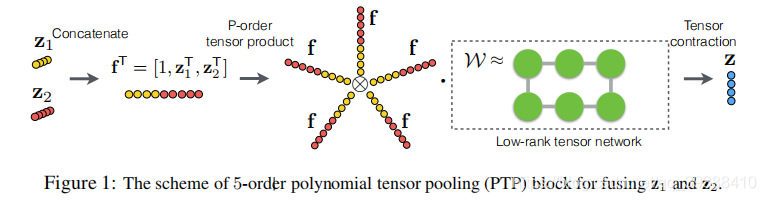

关于对矩阵的操作还有一种处理方法，就是如下图这种两两组合的方式。图出自NEURAL TENSOR NETWORK（NTN），本来是做实体关系检测的，同样也是博主觉得觉得这种方法也挺有意思的。这个小模块的大致的思路就是，让我们把APO都各自看成三个模态吧，然后两两组合得到矩阵T1，T2，再继续组合最后得到U这个融合/预测的结果。

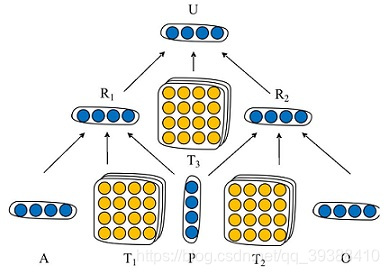